In [1]:
import xml.etree.ElementTree as ET
import pandas as pd
import janux as jx
import networkx as nx
import signal
import matplotlib.pyplot as plt

In [2]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)

# Read Demand XML

In [3]:
def parse_trips(xml_file):
    tree = ET.parse(xml_file)
    root = tree.getroot()

    trips_data = []
    
    for trip in root.findall("trip"):
        trip_info = trip.attrib
        trips_data.append(trip_info)

    return pd.DataFrame(trips_data)

In [4]:
demand_rou_file = "ingolstadt21.rou.xml"

connection_file = "ingolstadt.con.xml"
edge_file = "ingolstadt.edg.xml"
route_file = "ingolstadt.rou.xml"

In [5]:
df = parse_trips(demand_rou_file)
df.sample(10)

,id,type,depart,from,to
1387,carIn18173:1,default_016,58765.50,25190140#1,18809673#0
3531,carIn41328:1,default_017,60500.60,315358244,386687235
3453,carIn29640:1,default_017,60440.20,272042143,306240162#0
3219,carIn82041:1,default_017,60245.70,272042143,201238729#3
121,carIn99509:1,default_015,57719.80,-32978638#0,-315358244
2995,carIn132453:1,default_017,60087.70,-18809673#6,386687235
217,h18243c1:3,default_016,57812.00,399835085#1,18809673#0
2359,carIn128876:1,default_017,59591.10,128361102#0,201956811#0
1130,carIn65054:1,default_016,58597.40,124812856#0,-128361102#1
3915,h19359c1:2,default_017,60849.90,124812856#0,-128361102#1


# Reformat columns

In [6]:
# Scale departure times
df["depart"] = df["depart"].astype(float)
df["depart"] = df["depart"].astype(int)
df["depart"] = df["depart"] - min(df["depart"])

# Fix IDs
df["id"] = df.index

# Add kind column
df["kind"] = "Human"

# Rename columns
df.rename(columns={"depart": "start_time"}, inplace=True)
df.rename(columns={"from": "origin"}, inplace=True)
df.rename(columns={"to": "destination"}, inplace=True)

# Drop unnecessary columns
df.drop(columns=["type"], inplace=True)


# Build network

In [7]:
network = jx.build_digraph(connection_file, edge_file, route_file)

# Precleaning

In [8]:
df

,id,start_time,origin,destination,kind
0,0,0,201089423#0,-315358244,Human
1,1,0,124812856#0,-128361102#1,Human
2,2,2,128361109#1,-315358254#1,Human
3,3,4,124812856#0,306240162#0,Human
4,4,5,315358254#0,399835085#1,Human
...,...,...,...,...,...
4278,4278,3596,315358244,32978638#0,Human
4279,4279,3598,-32978638#0,-315358254#1,Human
4280,4280,3599,315358244,32978638#0,Human
4281,4281,3600,128361109#1,32978638#0,Human


### Remove isolated nodes

In [9]:
print("Removing trips with inaccessible origins or destinations...")

origins, destinations = df["origin"].unique(), df["destination"].unique()
bad_origins, bad_destinations = [], []

# origins with no outlinks
for origin in origins:
    paths_from_origin = nx.multi_source_dijkstra_path(network, [origin])
    del paths_from_origin[origin]
    if len(paths_from_origin) == 0:
        bad_origins.append(origin)
 
# inaccessible destinations       
for destination in destinations:
    paths_from_destination = nx.multi_source_dijkstra_path(network.reverse(), [destination])
    del paths_from_destination[destination]
    if len(paths_from_destination) == 0:
        bad_destinations.append(destination)
        
for idx, row in df.iterrows():
    if row["origin"] in bad_origins or row["destination"] in bad_destinations:
        df.drop(idx, inplace=True)
        
print(f"Deleted {len(bad_origins)} origins and {len(bad_destinations)} destinations")

Removing trips with inaccessible origins or destinations...
Deleted 3 origins and 5 destinations


### Remove same OD demands

In [10]:
print("Removing trips with identical origin and destination...")
counter = 0
for idx, row in df.iterrows():
    if row["origin"] == row["destination"]:
        df.drop(idx, inplace=True)
        counter += 1
print(f"Deleted {counter} trips with identical origin and destination")

Removing trips with identical origin and destination...
Deleted 1 trips with identical origin and destination


# Reset indices

In [11]:
df.reset_index(drop=True, inplace=True)
df["id"] = [i for i in range(len(df))]

df

,id,start_time,origin,destination,kind
0,0,0,201089423#0,-315358244,Human
1,1,0,124812856#0,-128361102#1,Human
2,2,2,128361109#1,-315358254#1,Human
3,3,4,124812856#0,306240162#0,Human
4,4,5,315358254#0,399835085#1,Human
...,...,...,...,...,...
4262,4262,3596,315358244,32978638#0,Human
4263,4263,3598,-32978638#0,-315358254#1,Human
4264,4264,3599,315358244,32978638#0,Human
4265,4265,3600,128361109#1,32978638#0,Human


# Remaining size of DF and timespan

In [12]:
print("Num rows: ", len(df))
print("Latest departure: ", max(df["start_time"]))
print("Earliest departure: ", min(df["start_time"]))
print("Timespan: ", max(df["start_time"]) - min(df["start_time"]))

Num rows:  4267
Latest departure:  3600
Earliest departure:  0
Timespan:  3600


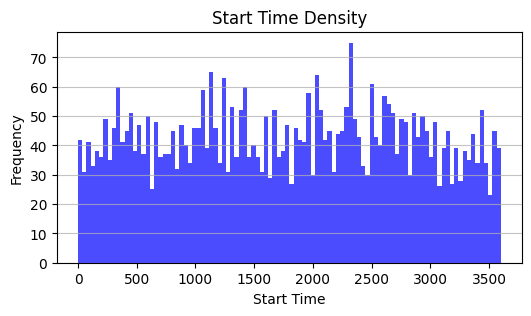

In [13]:
plt.figure(figsize=(6, 3))
plt.hist(df["start_time"], bins=100, color="blue", alpha=0.7)
plt.title("Start Time Density")
plt.xlabel("Start Time")
plt.ylabel("Frequency")
plt.grid(axis="y", alpha=0.75) 
plt.savefig("start_time_density.png", dpi=300, bbox_inches="tight")

# Prune ODs that we cannot generate paths

### Meaning no possible route choice

In [14]:
class TimeoutException(Exception):
    pass

def handler(signum, frame):
    raise TimeoutException("Function timed out")

def run_with_timeout(func, timeout, *args, **kwargs):
    signal.signal(signal.SIGALRM, handler)
    signal.alarm(timeout)  # Set the timeout alarm

    try:
        result = func(*args, **kwargs)
        signal.alarm(0)
        return result
    except TimeoutException as e:
        return None

In [15]:
def route_gen_process(network, df, num_paths, timeout=10):
    print(f"\nGenerating paths for {num_paths} paths...")
    path_gen_kwargs = {
                "number_of_paths": num_paths,
                "random_seed": 42,
                "num_samples": 20,
                "beta": -5,
                "weight": "time",
                "verbose": False
            }
    
    bad_demand = set()
    for idx, row in df.iterrows():
        print(f"\r{idx}/{len(df)}", end="")
        if (row["origin"], row["destination"]) in bad_demand:
            continue
        # Generate paths with timeout
        try:
            routes = run_with_timeout(jx.extended_generator, timeout, network, [row["origin"]], [row["destination"]], as_df=True, calc_free_flow=True, **path_gen_kwargs)
        except:
            routes = None
        if routes is None:
            #print(f"\n{row['id']} failed for {row['origin']} to {row['destination']}")
            bad_demand.add((row["origin"], row["destination"]))
      
    bad_demand  = list(bad_demand)
    print(f"\nBad demands for num_paths {num_paths}: {bad_demand}")
    
    return bad_demand

In [16]:
bad_demand = set()
counter = 0
try_up_to_num_paths = 5

for num_paths in range(try_up_to_num_paths):
    results = route_gen_process(network, df, num_paths+1, timeout=10)
    for idx, row in df.iterrows():
        if (row["origin"], row["destination"]) in results:
            df.drop(idx, inplace=True)       
            counter += 1
    for d in results:
        bad_demand.add(d)
     
bad_demand = list(bad_demand)
print(f"\nOverall bad demands: {bad_demand}")
print(f"Deleted {counter} trips with bad demand")
        
# Reset indices
df["id"] = [i for i in range(len(df))]
df.reset_index(drop=True, inplace=True)


Generating paths for 1 paths...
4266/4267
Bad demands for num_paths 1: []

Generating paths for 2 paths...
4266/4267
Bad demands for num_paths 2: [('202092675', '160314345#5'), ('-173169611#0', '201956820'), ('315358254#0', '-315358255#4'), ('51857518#1', '32978638#0'), ('266565295#5', '32999435'), ('-315358250#0', '-315358244'), ('128361102#0', '10427692#0'), ('124812856#1', '201956811#0'), ('399835085#1', '-315358254#1'), ('124812856#0', '201956811#0'), ('-30482615#4', '18809673#0'), ('266565295#5', '168702040#1'), ('315358255#0', '-315358254#1'), ('124812856#1', '201956810'), ('124812856#0', '201956810'), ('-32978638#0', '-24608846#0'), ('386687232#0', '136436466'), ('30482614', '30482615#1')]

Generating paths for 3 paths...
4266/4210
Bad demands for num_paths 3: [('-173169611#0', '201956811#0')]

Generating paths for 4 paths...
4266/4204
Bad demands for num_paths 4: []

Generating paths for 5 paths...
4266/4204
Bad demands for num_paths 5: []

Overall bad demands: [('399835085#1'

# Make demand data in our format

In [17]:
origin_indices = {origin_name : idx for idx, origin_name in enumerate(df["origin"].unique())}
destination_indices = {destination_name : idx for idx, destination_name in enumerate(df["destination"].unique())}

origin_names = {value: key for key, value in origin_indices.items()}
destination_names = {value: key for key, value in destination_indices.items()}

for idx, row in df.iterrows():
    df.at[idx, "origin"] = origin_indices[row["origin"]]
    df.at[idx, "destination"] = destination_indices[row["destination"]]

# Have a look

In [18]:
df

,id,start_time,origin,destination,kind
0,0,0,0,0,Human
1,1,0,1,1,Human
2,2,2,2,2,Human
3,3,4,1,3,Human
4,4,5,3,4,Human
...,...,...,...,...,...
4199,4199,3596,4,6,Human
4200,4200,3598,27,2,Human
4201,4201,3599,4,6,Human
4202,4202,3600,2,6,Human


In [19]:
df.to_csv("agents.csv", index=False)
print("Agents saved to agents.csv")

Agents saved to agents.csv


In [20]:
print("Origins:")
keys = [k for k in origin_names.keys()]
print(keys == sorted(keys))
origins = [origin_names[k] for k in keys]
print(origins)

Origins:
True
['201089423#0', '124812856#0', '128361109#1', '315358254#0', '315358244', '10425609#0', '24608844', '315358250#0', '-306240162#1', '128361102#0', '266565295#5', '201201950#1', '201201953#4', '399835085#1', '272042143', '24599188#0.94', '386687232#0', '22716069#0', '24634507', '224892339#0', '315358242#0', '-447569998#1', '-18809673#6', '24693977#1', '-54169231#2', '-26677216#0', '-10427692#1', '-32978638#0', '201950247#3', '-24634510#15', '-26677542#0', '26677213#0', '24634510#0', '176550249#3', '-24634413#2', '-160314345#5', '24634517#1', '18813598#2', '201238726#0.117', '22724699#7', '28319300#3', '22879845', '-399835085#0', '-173169611#0', '-160314345#2', '168702040#1', '24634416', '-24634509#7', '37681425#0', '-137454133#5', '-315358257#0.26', '201201945#0', '286646456#1', '136436468#0', '-25145012#5', '201201935#0', '-24634414#1', '23166741#2', '-24634510#5', '201238719#0', '24634513#0', '40888360#0', '40888354#1', '24634510#1', '-201238724', '24608846#0', '-22489236

In [21]:
print("Destinations:")
keys = [k for k in destination_names.keys()]
print(keys == sorted(keys))
destinations = [destination_names[k] for k in keys]
print(destinations)

Destinations:
True
['-315358244', '-128361102#1', '-315358254#1', '306240162#0', '399835085#1', '-25149001#4', '32978638#0', '386687235', '201956811#0', '-266565295#5', '201238729#3', '24634414#1', '201956820', '18809673#0', '-24634415', '24634517#13', '-26677539', '-24634510#5', '447569997#1', '40888354#0', '30482615#1', '-24634517#17', '-83304175#2', '26677539', '315358242#0', '-24634506#2', '-10427692#3', '24634510#6', '-24634505', '272042145', '201956810', '224892361#3', '-201238724', '26677541', '201238718#0', '-25145014#0', '24634509#1', '-315358242#1', '-315358242#0', '402600768#1', '28319300#3', '-201963533#4', '24608845', '-25190140#1', '137454133#2', '-40888354#2', '-315392062#4', '201201950#1', '40888354#1', '40888356#0', '138300620#0', '-201238718#0', '-22724699#1', '-32395288#1', '-315358251#0', '-25117391#2', '-218647954', '176550249#3', '-201089420#1', '-315358258', '22724699#7', '-24634513#5', '26677214#3', '224892339#0', '24634414#2', '-160314346#0', '201201953#10', '2